<a href="https://colab.research.google.com/github/wonderfulvamsi/DEEPDREAM/blob/master/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import models, transforms
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

In [5]:
IMAGE_PATH = '/content/drive/My Drive/NST/sky.png'
CUDA_ENABLED = False

# Deep dream configs
LAYER_ID = 28 # The layer to maximize the activations through
NUM_ITERATIONS = 5 # Number of iterations to update the input image with the layer's gradient
LR = 0.2

# We downscale the image recursively, apply the deep dream computation, scale up, and then blend with the original image 
# to achieve better result.
NUM_DOWNSCALES = 20
BLEND_ALPHA = 0.6

In [6]:
class DeepDream:
    def __init__(self, image):
        self.image = image
        self.model = models.vgg16(pretrained=True)
        if CUDA_ENABLED:
            self.model = self.model.cuda()
        self.modules = list(self.model.features.modules())
        
                # vgg16 use 224x224 images
        imgSize = 224
        self.transformMean = [0.485, 0.456, 0.406]
        self.transformStd = [0.229, 0.224, 0.225]
        self.transformNormalise = transforms.Normalize(
            mean=self.transformMean,
            std=self.transformStd
        )
        
        self.transformPreprocess = transforms.Compose([
            transforms.Resize((imgSize, imgSize)),
            transforms.ToTensor(),
            self.transformNormalise
        ])
        
        self.tensorMean = torch.Tensor(self.transformMean)
        if CUDA_ENABLED:
            self.tensorMean = self.tensorMean.cuda()

        self.tensorStd = torch.Tensor(self.transformStd)
        if CUDA_ENABLED:
            self.tensorStd = self.tensorStd.cuda()

    def toImage(self, input):
        return input * self.tensorStd + self.tensorMean

In [7]:
class DeepDream(DeepDream):
    def deepDream(self, image, layer, iterations, lr):
        transformed = self.transformPreprocess(image).unsqueeze(0)
        if CUDA_ENABLED:
            transformed = transformed.cuda()
        input = torch.autograd.Variable(transformed, requires_grad=True)
        self.model.zero_grad()
        for _ in range(iterations):
            out = input
            for layerId in range(layer):
                out = self.modules[layerId + 1](out)
            loss = out.norm()
            loss.backward()
            input.data = input.data + lr * input.grad.data

        input = input.data.squeeze()
        input.transpose_(0,1)
        input.transpose_(1,2)
        input = np.clip(self.toImage(input), 0, 1)
        return Image.fromarray(np.uint8(input*255))

In [8]:
class DeepDream(DeepDream):
    def deepDreamRecursive(self, image, layer, iterations, lr, num_downscales):
        if num_downscales > 0:
            # scale down the image
            image_small = image.filter(ImageFilter.GaussianBlur(2))
            small_size = (int(image.size[0]/2), int(image.size[1]/2))            
            if (small_size[0] == 0 or small_size[1] == 0):
                small_size = image.size
            image_small = image_small.resize(small_size, Image.ANTIALIAS)
            
            # run deepDreamRecursive on the scaled down image
            image_small = self.deepDreamRecursive(image_small, layer, iterations, lr, num_downscales-1)
            
            # Scale up the result image to the original size
            image_large = image_small.resize(image.size, Image.ANTIALIAS)
            
            # Blend the two image
            image = ImageChops.blend(image, image_large, BLEND_ALPHA)
        img_result = self.deepDream(image, layer, iterations, lr)
        img_result = img_result.resize(image.size)
        return img_result
    
    def deepDreamProcess(self):
        return self.deepDreamRecursive(self.image, LAYER_ID, NUM_ITERATIONS, LR, NUM_DOWNSCALES)

Text(0.5, 1.0, 'Image loaded from /content/drive/My Drive/NST/sky.png')

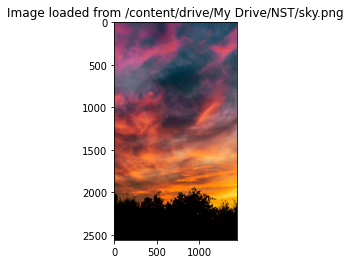

In [9]:
img = Image.open(IMAGE_PATH)
  
pyplot.imshow(img)
pyplot.title("Image loaded from " + IMAGE_PATH)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Text(0.5, 1.0, 'Deep dream image')

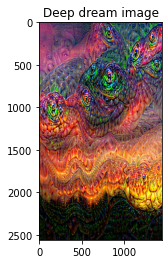

In [10]:
img_deep_dream = DeepDream(img).deepDreamProcess()
pyplot.imshow(img_deep_dream)
pyplot.title("Deep dream image")